# モンテカルロ法
DPを用いて最適評価関数と最適方策を得る手法は環境のモデルが既知である必要がある。

モンテカルロ法は、未知の環境においてデータのサンプリングを行うことで推定を行う手法の総称である。

## 分布モデルとサンプルモデル
**分布モデル**は確率分布として表されたモデルを指す。

| さいころの目の和 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 |
| :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
| 確率 | $\frac 1 {36}$ | $\frac 2 {36}$ | $\frac 3 {36}$ | $\frac 4 {36}$ | $\frac 5 {36}$ | $\frac 6 {36}$ | $\frac 5{36}$ | $\frac 4 {36}$ | $\frac 3 {36}$ | $\frac 2 {36}$ | $\frac 1 {36}$ |

一方、**サンプルモデル**はサンプリングができるモデルを指す。

## 分布モデルにおける期待値の算出
分布モデルでは確率分布があらかじめわかっているため、以下のように算出できる。

In [4]:
p = {2: 1/36, 3: 2/36, 4: 3/36, 5: 4/36, 6: 5/36, 7: 6/36, 8: 5/36, 9: 4/36, 10: 3/36, 11: 2/36, 12: 1/36}

V = sum(k * v for k, v in p.items())
print(V)

7.0


## サンプルモデルにおける期待値の算出
十分な数のサンプルを使うことで、期待値は正しい値に収束する。

十分な回数サンプルを取得し、計算することで推定する手法が**モンテカルロ法**である。

以下にモンテカルロ法で期待値を算出するプログラムを示す。真の期待値である$7$に近い値を得られていることがわかる。

In [5]:
import numpy as np

def sample(dices):
    x = 0
    for i in range(dices):
        x += np.random.randint(1, 7)
    return x

trial = 10000

samples = []
for i in range(trial):
    s = sample(2)
    samples.append(s)
    
V = sum(samples) / len(samples)
print(V)

7.0092


上記のプログラムではサンプルを全て求めてから期待値を計算している。

ここで、N個のデータから得られる平均値は以下のようにして求められる。

$$
V_n = \frac {s_1 + s_2 + ... + s_n} n
$$

これを変形すると以下のようになる。

$$
V_n = \frac {s_1 + s_2 + ... + s_n} n\\
V_n = \frac {s_n} n + \frac {n - 1} n \frac {s_1 + s_2 + ... + s_{n - 1}} {n - 1}\\
V_n = \frac {s_n} n + \biggl( 1 - \frac 1 n \biggr) V_{n - 1}\\
V_n = V_{n - 1} + \frac 1 n (s_n - V_{n - 1})\\
$$

よって、サンプルを得るたびにそれまでの平均値と新たに得たサンプルの値を用いて平均値を更新できる。

これを実装すると以下のようになる。

In [6]:
trial = 10000
V, n = 0, 0

for i in range(trial):
    s = sample(2)
    n += 1
    V += (s - V) / n
print(V)

7.040399999999987


## 価値関数をモンテカルロ法で求める
まず、価値関数は以下の式で表される。

$$
u_\pi (s) = \mathbb{E} [G|s]
$$

ここにモンテカルロ法を適用することを考えると、$n$回目の試行で得た収益を$G^{(n)}$として以下の式で表すことができる。なお、この際に方策$\pi$を用いる。

$$
V_\pi(s) = \frac {G^{(1)} + G^{(2)} + ... + G^{(n)}} n
$$

これを**各状態について**求めればよい。このとき、各状態の価値関数の値どうしは独立して算出されていることに注意が必要である。

## 効率の良い求め方
例として、状態$A$からスタートし、状態$B$と状態$C$を順に経由してゴールすることを考える。

このとき、$A$から$B$、$B$から$C$、$C$からゴールへの移動に対する報酬をそれぞれ$R_0, R_1, R_2$とすると、各状態からの移動を考えたとき収益$G_A, G_B, G_C$は以下のように求められる。

$$
\begin{align*}
G_A &= R_0 + \gamma R_1 + \gamma^2 R_2\\
G_B &= R_1 + \gamma R_2\\
G_C &= R_2
\end{align*}
$$

これを変形すると、最後の状態から以下のように逐次的に求めることができる。

$$
\begin{align*}
G_C &= R_2\\
G_B &= R_1 + \gamma G_C\\
G_A &= R_0 + \gamma G_B\\
\end{align*}
$$

## モンテカルロ法を実装する
上記の式を用いて、モンテカルロ法で方策の評価を行うプログラムを実装する。

まず、DP法で用いた`GridWorld`を定義する。DP法で用いたものと比べて、環境が状態を保持しており、状態と行動を渡すと次の状態を返す`step`メソッドが実装されている。

In [7]:
import numpy as np
from utils import Renderer

class GridWorld:
    def __init__(self):
        self.action_space = [0, 1, 2, 3]  # 上、下、左、右
        self.action_map = {
            0: (-1, 0),  # 上
            1: (1, 0),   # 下
            2: (0, -1),  # 左
            3: (0, 1),   # 右
        }
        self.reward_map = np.array([
            [0, 0, 0, 1],
            [0, None, 0, -1],
            [0, 0, 0, 0],
        ])
        self.goal_state = (0, 3)  # ゴール地点
        self.wall_state = (1, 1)  # 壁の地点
        self.start_state = (2, 0)  # スタート地点
        self.now_state = self.start_state

    @property
    def height(self):
        return self.reward_map.shape[0]
    
    @property
    def width(self):
        return self.reward_map.shape[1]
    
    @property
    def shape(self):
        return self.reward_map.shape

    def actions(self):
        return self.action_space
    
    # 状態を取得
    def states(self):
        for i in range(self.height):
            for j in range(self.width):
                yield (i, j)
                
    def next_state(self, state, action):
        move = self.action_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        nx, ny = next_state
        
        # ワールドの端なら状態は変わらない
        if nx < 0 or nx >= self.height or ny < 0 or ny >= self.width:
            return state
        # 壁なら状態は変わらない
        elif self.reward_map[nx, ny] is None:
            return state
        
        return next_state
    
    def step(self, action):
        # 行動を選択
        next_state = self.next_state(self.now_state, action)
        reward = self.reward(next_state)
        
        # 状態を更新
        self.now_state = next_state
        
        done = True if next_state == self.goal_state else False

        return next_state, reward, done

    def reset(self):
        self.now_state = self.start_state
        return self.now_state

    def reward(self, state):
        return self.reward_map[state]
    
    def render_v(self, v=None, policy=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state, self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state, self.wall_state)
        renderer.render_q(q, print_value)

### Agentの実装
ランダムな方策に従って行動するエージェントを実装する。

`eval`メソッドを用いることで、蓄積したメモリのデータを使って価値関数の値`V`を更新する。

In [8]:
from collections import defaultdict


class RandomAgent:
    def __init__(self, gamma, action_size):
        self.gamma = gamma
        self.action_size = action_size

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)
        self.cnts = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def eval(self):
        G = 0
        for data in reversed(self.memory): # 最後の状態から逐次的に更新する
            state, action, reward = data
            G = reward + self.gamma * G
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]   

### モンテカルロ法を用いる
`GridWorld`クラスと`RandomAgent`クラスを用いてモンテカルロ法を実装する。

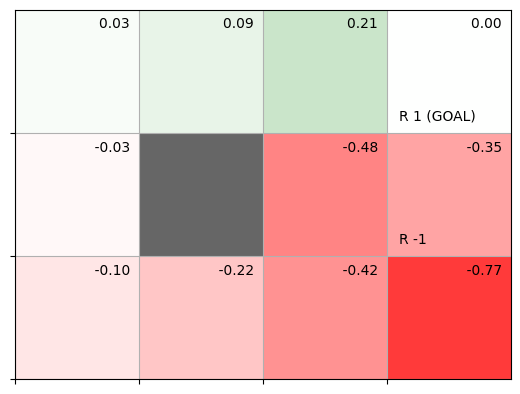

In [9]:
env = GridWorld()
agent = RandomAgent(gamma=0.9, action_size=len(env.action_space))

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        
        if done:
            agent.eval()
            break
        
        state = next_state

env.render_v(agent.V)

## 考察
この結果は、DP法を用いてランダムな方策の評価を行った結果とほとんど一致しており、モンテカルロ法でもおおむね正しい結果を得られていることがわかる。

モンテカルロ法ではモデルの情報がサンプリングでのみ得られる場合でも有効だと考えられる。

## 方策制御
ここまではモンテカルロ法で方策の評価を行う方法を述べてきたが、最適な方策を得る方法についても考える。

DP法を用いた手法では、方策反復法などで価値関数の算出と方策の更新を繰り返すことで最適な方策を得ていた。

このときの方策の更新には以下の式を用いた。

$$
\begin{align*}
\mu(s) &= \argmax_a Q(s, a)\\
&= \argmax_a \sum_{s'} p(s'|s, a) \{r(s, a, s') + \gamma V(s')\}
\end{align*}
$$

モンテカルロ法でもこの式を用いることができれば最適方策を得ることが可能になるが、サンプルモデルでは$p(s'|s, a)$や$r(s, a, s')$を知ることはできないためこの式をそのまま使うことはできない。

そこで、$Q$関数を用いて方策を更新することを考える。$Q$関数の定義は「**状態$s$のときに行動$a$をとった際の収益の期待値**」であるから、以下のように表される。

$$
\begin{align*}
Q_\pi(s, a) &= \mathbb{E} [G_t|S_t = s, A_t = a]\\
&= \frac {G^{(1)} + G^{(2)} + ... + G^{(n)}} n
\end{align*}
$$

また、$n$個目の新たなサンプルを得たときの更新式は以下のように表すことができる。

$$
Q_n(s, a) = Q_{n - 1}(s, a) + \frac 1 n \biggl\{ G^{(n)} - Q_{n - 1}(s, a) \biggr\}
$$

この式は状態価値関数を更新する以下の式と同じ形をとっていることがわかる。

$$
V_n(s) = V_{n - 1}(s) + \frac 1 n \biggl\{ G^{(n)} - V_{n - 1}(s) \biggr\}
$$

## Q関数を用いた方策制御の実装
以下のプログラムは`RandomAgent`を基に構成されており、状態価値関数の代わりにQ関数を算出し、探索を行うたびに方策を更新している。

但し、このプログラムには以下のような問題がある。

1. 1回探索した後に方策を更新した際に、ある状態における行動が確率1で固定されてしまい、十分に探索できない。
2. Q関数を更新するときに、過去に探索した際の収益と新たに探索した際の収益の重みが同じ。

In [10]:
def greedy_probs(Q, state, action_size):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    action_probs = {action: 0.0 for action in range(action_size)}
    action_probs[max_action] = 1.0
    return action_probs

class McAgent:
    def __init__(self, gamma, action_size):
        self.gamma = gamma
        self.action_size = action_size

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.cnts = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p = probs)
    
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = reward + self.gamma * G
            key = (state, action)
            self.cnts[key] += 1
            self.Q[key] += (G - self.Q[key]) / self.cnts[key]

            self.pi[state] = greedy_probs(self.Q, state, self.action_size)

## 改善
上記のプログラムにおける2つの問題を、それぞれ以下のようにして修正する。

1. 1回探索した後に方策を更新した際に、ある状態における行動が確率1で固定されてしまい、十分に探索できない。\
$\varepsilon$-greedy法を適用し、エージェントの行動に多少のランダム性を持たせることで十分に探索できるようにする。
2. Q関数を更新するときに、過去に探索した際の収益と新たに探索した際の収益の重みが同じ。\
Q関数の値を更新する際に、重みを$\frac 1 n$ではなく固定値$\alpha$とすることで最近の探索結果ほど重視されるようにする。

これらを踏まえて修正したプログラムを以下に示す。

In [11]:
def greedy_probs_fixed(Q, state, epsilon, action_size):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    action_probs = {action: epsilon / action_size for action in range(action_size)}
    action_probs[max_action] += (1.0 - epsilon)
    return action_probs

class McAgentFixed:
    def __init__(self, gamma, epsilon, alpha, action_size):
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.action_size = action_size

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p = probs)
    
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = reward + self.gamma * G
            key = (state, action)
            self.Q[key] += (G - self.Q[key]) * self.alpha # 固定値を使用して更新

            self.pi[state] = greedy_probs_fixed(self.Q, state, self.epsilon, self.action_size)

## 実行する
上記で実装した`McAgentFixed`クラスを使い、Q関数の値を実際に計算する。

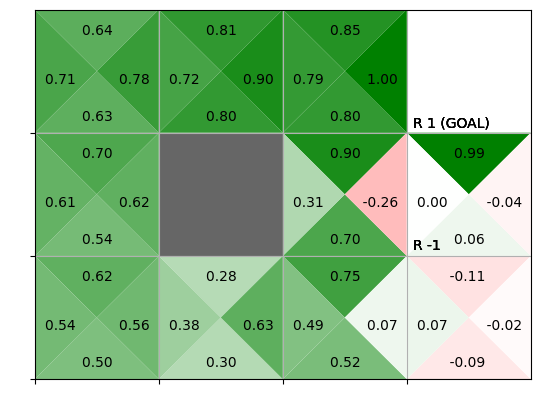

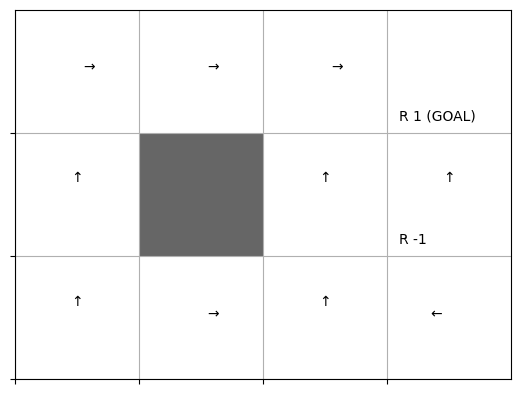

In [13]:
env = GridWorld()
agent = McAgentFixed(gamma=0.9, epsilon=0.1, alpha=0.1, action_size=len(env.action_space))

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        agent.add(state, action, reward)

        if done:
            agent.update()
            break

        state = next_state

env.render_q(agent.Q)

## 考察
この結果から、ほぼ最適な方策が得られていると考える。

また、バンディット問題と同様に、$\varepsilon$の値や$\alpha$の値を変化させることで、最適方策を得る精度や収束までの速度が変化すると考えられる。

## 方策オフ型と重点サンプリング
モンテカルロ法と$\varepsilon$-greedy法を組み合わせた手法では、最適に近い方策が得られたが、一定の確率で探索を行っているため完全に最適な方策を得られているわけではない。

### 方策オン型と方策オフ型
- 方策オン型(on-policy): 自分で得た経験から自分の方策を改善する
- 方策オフ型(off-policy): 自分とは他の場所で得た経験から自分の方策を改善する

- ターゲット方策(Target Policy): 評価・改善の対象となる方策
- 挙動方策(Behavior Policy): 実際に行動を起こす際に用いる方策

ここまで、ターゲット方策と挙動方策を区別することなく使ってきており、これは方策オン型である。

方策オフ型では、「活用」を行うターゲット方策と「探索」を行う挙動方策に分けて考えることができる。

ただし、挙動方策で得られたサンプルデータを使ってターゲット方策を更新する場合、期待値を求める際に工夫が必要であり、その際に**重点サンプリング**が用いられる。

### 重点サンプリング
**重点サンプリング(Importance Sampling)**は、ある確率分布の期待値を、別の確率分布からサンプリングしたデータを使って計算する手法である。